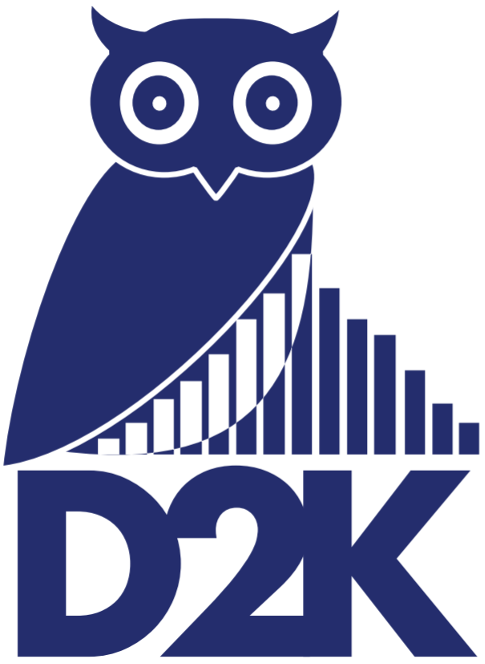 

<center>

# Welcome to COMP 680 #
### Statistics for Computing and Data Science ###

### Homework 6 ###

In [1]:
### standard imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline  
plt.style.use('fivethirtyeight')
plt.rcParams["patch.force_edgecolor"] = True
import seaborn as sns

import statsmodels.api as sm
from statsmodels.sandbox.predict_functional import predict_functional
import scipy.stats as st

import warnings
warnings.filterwarnings("ignore")

## NHANES Case Study

In this homework, we will be working with the [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2015) data again. We will perform the same processing and cleaning of the data as before:

In [2]:
nhanes = pd.read_csv("nhanes_2015_2016.csv")
# fix column names to be informative
new_col_names = {'SEQN':'ID',
                 'ALQ130':'Avg_drinks_per_day', 'SMQ020': 'Smoker', 
                 'RIAGENDR':'Gender', 'RIDAGEYR':'Age', 'RIDRETH1':'Race', 
                 'DMDCITZN':'Citizenship', 'DMDEDUC2':'Education_Level', 
                 'DMDMARTL':'Marital_Status', 'INDFMPIR':'Family_PIR', 
                 'BPXSY1':'Systolic_Blood_Pressure', 'BPXDI1':'Diastolic_Blood_Pressure', 
                 'BMXWT':'Weight', 'BMXHT':'Height', 'BMXBMI':'BMI', 
                 'BMXLEG':'Leg_Length', 'BMXARML':'Arm_Length', 
                 'BMXARMC': 'Arm_Circumference', 'BMXWAIST':'Waist_Circumference'}
nhanes.rename(columns=new_col_names, inplace=True)
# replace some code as missing values
nhanes['ALQ101'] =  nhanes['ALQ101'].replace({7:np.NaN, 9:np.NaN})
nhanes['ALQ110'] =  nhanes['ALQ110'].replace({7:np.NaN, 9:np.NaN})
nhanes['Avg_drinks_per_day'] =  nhanes['Avg_drinks_per_day'].replace({777:np.NaN, 999:np.NaN})
nhanes['Smoker'] = nhanes['Smoker'].replace({7:np.NaN, 9:np.NaN})
nhanes['Education_Level'] = nhanes['Education_Level'].replace({7:np.NaN, 9:np.NaN})
nhanes['Marital_Status'] = nhanes['Marital_Status'].replace({77:np.NaN})
nhanes['Citizenship'] = nhanes['Citizenship'].replace({7:np.NaN, 9:np.NaN})
# there are quite a few missing values but most model will exclude them
nhanes.head()

ID  ALQ101  ALQ110  Avg_drinks_per_day  Smoker  Gender  Age  Race  \
0  83732     1.0     NaN                 1.0     1.0       1   62     3   
1  83733     1.0     NaN                 6.0     1.0       1   53     3   
2  83734     1.0     NaN                 NaN     1.0       1   78     3   
3  83735     2.0     1.0                 1.0     2.0       2   56     3   
4  83736     2.0     1.0                 1.0     2.0       2   42     4   

   Citizenship  Education_Level  ...  BPXSY2  BPXDI2  Weight  Height   BMI  \
0          1.0              5.0  ...   124.0    64.0    94.8   184.5  27.8   
1          2.0              3.0  ...   140.0    88.0    90.4   171.4  30.8   
2          1.0              3.0  ...   132.0    44.0    83.4   170.1  28.8   
3          1.0              5.0  ...   134.0    68.0   109.8   160.9  42.4   
4          1.0              4.0  ...   114.0    54.0    55.2   164.9  20.3   

   Leg_Length  Arm_Length  Arm_Circumference  Waist_Circumference  HIQ210  
0        43.3        43.6               35.9                101.1     2.0  
1        38.0        40.0               33.2                107.9     NaN  
2        35.6        37.0               31.0                116.5     2.0  
3        38.5        37.7               38.3                110.1     2.0  
4        37.4        36.0               27.2                 80.4     2.0  

[5 rows x 28 columns]

### Translation of all the categorical variables
For convenience, we list all the number code with informative text category names here, and we code missing values in those categorical variables properly.

- Gender:
    - 1: Male
    - 2: Female
- Smoker (smoked at least 100 cigarettes in life):
    - 1: Yes
    - 2: No
- Race: 
    - 1: Mexican American
    - 2: Other Hispanic
    - 3: Non-Hispanic White
    - 4: Non-Hispanic Black
    - 5: Other Race Including Multi-Racial
- Education Level:
    - 1: < 9th grade
    - 2: 9-11th grade
    - 3: HS/GED
    - 4: Some college/AA
    - 5: College
- Marital Status:
    - 1: Married
    - 2: Widowed
    - 3: Divorced
    - 4: Separated
    - 5: Never married
    - 6: Living w/partner
- Citizenship:
    - 1: US Citizen
    - 2: Non US Citizen

**Question 1:** 
We generate a binary variable reflecting whether a person has smoked at least 100 cigarettes in life, based on the original [SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020) variable in NHANES, renamed above to be `Smoker`.

In [4]:
# recode Smoker so 1 is smoker and 0 is non-smoker
# if 1 is smoker, 2 is non-smoker 
# the model will be predicting probability of non-smoker
# because default baseline category is the smallest number
# or the first string in alphabetical order
nhanes['Smoker'] = nhanes['Smoker'].replace({2:0})
nhanes.head()

ID  ALQ101  ALQ110  Avg_drinks_per_day  Smoker  Gender  Age  Race  \
0  83732     1.0     NaN                 1.0     1.0       1   62     3   
1  83733     1.0     NaN                 6.0     1.0       1   53     3   
2  83734     1.0     NaN                 NaN     1.0       1   78     3   
3  83735     2.0     1.0                 1.0     0.0       2   56     3   
4  83736     2.0     1.0                 1.0     0.0       2   42     4   

   Citizenship  Education_Level  ...  BPXSY2  BPXDI2  Weight  Height   BMI  \
0          1.0              5.0  ...   124.0    64.0    94.8   184.5  27.8   
1          2.0              3.0  ...   140.0    88.0    90.4   171.4  30.8   
2          1.0              3.0  ...   132.0    44.0    83.4   170.1  28.8   
3          1.0              5.0  ...   134.0    68.0   109.8   160.9  42.4   
4          1.0              4.0  ...   114.0    54.0    55.2   164.9  20.3   

   Leg_Length  Arm_Length  Arm_Circumference  Waist_Circumference  HIQ210  
0        43.3        43.6               35.9                101.1     2.0  
1        38.0        40.0               33.2                107.9     NaN  
2        35.6        37.0               31.0                116.5     2.0  
3        38.5        37.7               38.3                110.1     2.0  
4        37.4        36.0               27.2                 80.4     2.0  

[5 rows x 28 columns]

 **1.1:** Fit a logistic regression model [sm.GLM.from_formula](https://www.statsmodels.org/dev/examples/notebooks/generated/glm_formula.html) using only one covariate Gender to predict smoking status. Reminder the variable `Gender` is coded as following, but you should include in the model correctly as a categorical variable, and use the Male category as reference!
 - Gender:
    - 1: Male
    - 2: Female

In [5]:
# enter your code here
model1 = sm.GLM.from_formula('Smoker ~ C(Gender)', 
                             family=sm.families.Binomial(), data=nhanes)
result1 = model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Smoker   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5723
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3734.8
Date:                Mon, 12 Dec 2022   Deviance:                       7469.6
Time:                        18:45:06   Pearson chi2:                 5.72e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04428
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0530      0.038      1.391      0.164      -0.022       0.128
C(Gender)[T.2]    -0.8774      0.055    -15.908      0.000      -0.985      -0.769
==================================================================================
"""

**1.2:** Calculate the probability, odds, and log odds of the variable `Smoker` for females and for males. What is the log odds of smoking for males?  Then calculate the log odds ratio for females relative to males, that is the log odds ratio of females minus the log odds ratio of males.

In [11]:
# enter your code here
smoke_gender = nhanes.pivot_table(index='Gender', columns='Smoker', 
                                  values='ID', aggfunc='count',
                                  margins=True)
smoke_gender.rename(index={1:'male', 2:'female'}, 
                    columns={0:'non-smoker', 1:'smoker'},
                    inplace=True)
smoke_gender['smoke_prob'] = smoke_gender['smoker']/smoke_gender['All']
smoke_gender['smoke_odds'] = smoke_gender['smoker']/smoke_gender['non-smoker']
smoke_gender['smoke_log_odds'] = np.log(smoke_gender['smoke_odds'])
smoke_gender

Smoker  non-smoker  smoker   All  smoke_prob  smoke_odds  smoke_log_odds
Gender                                                                  
male          1340    1413  2753    0.513258    1.054478        0.053045
female        2066     906  2972    0.304845    0.438529       -0.824330
All           3406    2319  5725    0.405066    0.680857       -0.384403

In [17]:
# Log odds ratio for males:
lodds_male = smoke_gender.loc['male', 'smoke_log_odds'] 
# Log odds ratio for females relative to males:
lodds_female = smoke_gender.loc['female', 'smoke_log_odds'] \
                - smoke_gender.loc['male', 'smoke_log_odds'] 

In [18]:
# print out result
print('Smoking log odds ratio for male: %.4f' % lodds_male)
print('Smoking log odds ratio for female: %.4f' % lodds_female)

Smoking log odds ratio for male: 0.0530
Smoking log odds ratio for female: -0.8774


**1.3:** If your calculation in **1.2** is correct, you should end up with almost identical numbers as the coefficients in model in **1.1** (assuming you fit the model correctly). What are the interpretations for the intercept and slope for the model in **1.1**? I hope the above exercise helps with the interpretations!

**Solution:**  

Interpretation for intercept: Since the male is the refernce category in this case, the intercept is the log odds ratio of smoking for male. 

Interpretation for slope: The slope is the log odds ratio of smoking for female relative to male, or log odds of smoking for female - log odds of smoking for male.


**1.4:** Based on the model results in **1.1**, can we conclude that more than 50% of male are smokers in general population?

**Solution:**: 

No. This is equivalent to hypothesis testing on the intercept to see if it is significantly different from 0, and specifically test if the intercept is positive if more than 50% males are smokers. But the p-value is 0.164 which is larger than 0.05 (even if we apply a one-sided test and divide the p-value by 2, it is still larger than 0.05). Therefore, we fail to reject the null hypothesis and cannot conclude that more than 50% of male are smokers in the general population.

**1.5:** Does there appear to be a significant difference between the smoking status of female and male? If so, can you quantify the difference based on the model in **1.1**: how much more likely that male are smokers than female?

In [19]:
# calculate odds ratio of male over female
# notice the model coefficient is female over male, so need to do 1 / 
1 / np.exp(result1.params[1])

2.4045813976452175

**Solution:**: 

Yes. This is equivalent to hypothesis testing on the slope for female to see if it is significantly different from 0, and the p-value is much smaller than 0.05. Therefore, we reject the null hypothesis and conclude that there is a significant differnce between the smoking status of female and male. In particular, male are about 2.4 times more likely to be a smoker.

**Question 2:** We will build upon the model in **Question 1** by adding more covariates from the data.

**2.1:** Let's first add age to the model, so fit a logistic regression model using Gender and Age to predict smoking status.

In [9]:
# enter your code here
model2 = sm.GLM.from_formula('Smoker ~ C(Gender) + Age', family=sm.families.Binomial(), data=nhanes)
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Smoker   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5722
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3637.6
Date:                Mon, 28 Nov 2022   Deviance:                       7275.2
Time:                        15:08:14   Pearson chi2:                 5.73e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07618
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.9656      0.084    -11.546      0.000      -1.130      -0.802
C(Gender)[T.2]    -0.8978      0.056    -15.967      0.000      -1.008      -0.788
Age                0.0211      0.002     13.720      0.000       0.018       0.024
==================================================================================
"""

**2.2:** Based on the model result in **2.1**, how do we interpret all the coefficients?

**Solution:**  

Interpretation for intercept: log odds ratio for smoking of male age 0 is -0.9656 (or not interpretable is fine).

Interpretation for slope of female: the log odds ratio of smoking for female relative to male is -0.8978, **given the same age**.

Interpretation for slope of age: for **both male or female**, if age increase by 1, log odds ratio of smoking increase by 0.0211.

**2.3:** Let's now add an interaction term of age and gender to the model!

In [20]:
# enter your code here
model3 = sm.GLM.from_formula('Smoker ~ C(Gender) + Age + C(Gender) * Age', family=sm.families.Binomial(), data=nhanes)
result3 = model3.fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Smoker   No. Observations:                 5725
Model:                            GLM   Df Residuals:                     5721
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3629.2
Date:                Mon, 12 Dec 2022   Deviance:                       7258.5
Time:                        20:51:30   Pearson chi2:                 5.72e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.07888
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.2604      0.112    -11.294      0.000      -1.479      -1.042
C(Gender)[T.2]        -0.2772      0.161     -1.719      0.086      -0.593       0.039
Age                    0.0273      0.002     12.533      0.000       0.023       0.032
C(Gender)[T.2]:Age    -0.0126      0.003     -4.087      0.000      -0.019      -0.007
======================================================================================
"""

**2.4:** Based on the model result in **2.3**, how do we interpret all the coefficients? What does it imply if the interaction term is significant?

**Solution:**  

- Interpretation for intercept: log odds ratio for smoking of male age 0 is -0.9656 (or not interpretable is fine)
- Interpretation for slope of female: the log odds ratio of smoking for female age 0 relative to male is -0.8978. However, this slope is no longer significant.
- Interpretation for slope of age: **for male**, if age increase by 1, log odds ratio of smoking increase by 0.0273.
- Interpretation for slope of the interaction: **for female**, if age increase by 1, log odds ratio of smoking only increase by 0.0273-0.0126 = 0.0147.
- The interaction term indicates the effect of age in smoking status is different for male and for female, in particular, males are more likely to smoke as age increases than female. It also indicates the difference between log odds ratio of smoking between male and female now depends on age, in particular, as age increases, this difference becomes larger.

**2.5:** Adding the following variables to model in **2.3**. Based on results, make some general conclusions about how each variable affects the probability of smoking. As a reminder, the coding for the following vriables are listed:
- Race: 
    - 1: Mexican American
    - 2: Other Hispanic
    - 3: Non-Hispanic White
    - 4: Non-Hispanic Black
    - 5: Other Race Including Multi-Racial
- Education_Level:
    - 1: < 9th grade
    - 2: 9-11th grade
    - 3: HS/GED
    - 4: Some college/AA
    - 5: College
- Marital_Status:
    - 1: Married
    - 2: Widowed
    - 3: Divorced
    - 4: Separated
    - 5: Never married
    - 6: Living w/partner
- BMI: numerical

In [21]:
# enter your code here
model4 = sm.GLM.from_formula('Smoker ~ C(Gender) + Age + C(Gender) * Age + C(Race) + C(Education_Level) + C(Marital_Status) + BMI', family=sm.families.Binomial(), data=nhanes)
result4 = model4.fit()
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Smoker   No. Observations:                 5393
Model:                            GLM   Df Residuals:                     5375
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3288.0
Date:                Mon, 12 Dec 2022   Deviance:                       6576.0
Time:                        20:51:33   Pearson chi2:                 5.38e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1308
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.8850      0.222     -8.504      0.000      -2.319      -1.451
C(Gender)[T.2]               -0.2117      0.180     -1.176      0.240      -0.565       0.141
C(Race)[T.2]                  0.1549      0.110      1.413      0.158      -0.060       0.370
C(Race)[T.3]                  0.7124      0.096      7.423      0.000       0.524       0.901
C(Race)[T.4]                  0.2525      0.102      2.473      0.013       0.052       0.453
C(Race)[T.5]                  0.0270      0.114      0.237      0.813      -0.197       0.251
C(Education_Level)[T.2.0]     0.7081      0.123      5.748      0.000       0.467       0.950
C(Education_Level)[T.3.0]     0.4671      0.112      4.173      0.000       0.248       0.686
C(Education_Level)[T.4.0]     0.3308      0.110      3.010      0.003       0.115       0.546
C(Education_Level)[T.5.0]    -0.4797      0.117     -4.089      0.000      -0.710      -0.250
C(Marital_Status)[T.2.0]      0.2620      0.129      2.027      0.043       0.009       0.515
C(Marital_Status)[T.3.0]      0.5419      0.102      5.305      0.000       0.342       0.742
C(Marital_Status)[T.4.0]      0.6558      0.165      3.974      0.000       0.332       0.979
C(Marital_Status)[T.5.0]      0.3371      0.089      3.768      0.000       0.162       0.512
C(Marital_Status)[T.6.0]      0.5214      0.106      4.900      0.000       0.313       0.730
Age                           0.0256      0.003      9.730      0.000       0.020       0.031
C(Gender)[T.2]:Age           -0.0156      0.003     -4.493      0.000      -0.022      -0.009
BMI                           0.0024      0.004      0.568      0.570      -0.006       0.011
=============================================================================================
"""

**Solution:**  

This is open-ended, but some general conclusion can be:
- BMI does not affect probability of smoking for the two people with same gender, age, race, education level and marital status. 
- Compared to baseline Mexican American, both White and Black are more likely to smoke given the same gender, age, education level and marital status.
- Compared to married people, all the other marital status are more likely to smoke given the same gender, age, race and education level.
- Someone with college degree is less likely to smoke compared to someone without, but for the same gender, age, race and marital status. 
- The most likely smokers are old, white male with low education level and seperated from the spouse(>_<)

**Question 3:** We will create a categorical variable for drinking status based on [`ALQ101` and `ALQ110`](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.htm#Codebook):
- driking
    - 0: fewer than 12 alcohol drinks in lifetime (`ALQ110`=2).
    - 1: more than 12 alcohol drinks in lifetime but not in a year (`ALQ110`=1).
    - 2: more than 12 alcohol drinks in a year (`ALQ101`=1).

In [22]:
nhanes['Drinking'] = nhanes['ALQ110']
nhanes.loc[nhanes['ALQ110']==2, 'Drinking'] = 0
nhanes.loc[nhanes['ALQ101']==1, 'Drinking'] = 2
# check for counts
nhanes['Drinking'].value_counts()

2.0    3477
0.0     979
1.0     747
Name: Drinking, dtype: int64

**3.1:** Fit a multinomial regression model [sm.MNLogit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.MNLogit.html#statsmodels.discrete.discrete_model.MNLogit) using the following covariates:
- Gender:
    - 1: Male
    - 2: Female
- Age: numerical
- BMI: numerical

**Note:** MNLogit function does not support formula and cannot handle NaNs, so you need to do dummy variable coding and drop all rows with NaNs. 

In [24]:
# enter your code here
# notice MNLogit does not support formula and cannot handle NaN
# need to create a dummy variable for Female
nhanes['Female'] = (nhanes['Gender']==2)*1
# take out the columns and drop NaN
dat = nhanes[['Drinking', 'Female', 'Age' ,'BMI']].dropna()
dat.endog = dat['Drinking']
dat.exog = sm.add_constant(dat[['Female', 'Age' ,'BMI']])
model5 = sm.MNLogit(dat.endog, dat.exog)
result5 = model5.fit()
result5.summary()

Optimization terminated successfully.
         Current function value: 0.822527
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               Drinking   No. Observations:                 5146
Model:                        MNLogit   Df Residuals:                     5138
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.04472
Time:                        20:52:27   Log-Likelihood:                -4232.7
converged:                       True   LL-Null:                       -4430.9
Covariance Type:            nonrobust   LLR p-value:                 1.751e-82
==============================================================================
Drinking=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5713      0.248     -6.334      0.000      -2.057      -1.085
Female         0.0203      0.107      0.189      0.850      -0.189       0.230
Age            0.0108      0.003      4.066      0.000       0.006       0.016
BMI            0.0251      0.007      3.755      0.000       0.012       0.038
------------------------------------------------------------------------------
Drinking=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6296      0.184      8.840      0.000       1.268       1.991
Female        -1.1401      0.078    -14.609      0.000      -1.293      -0.987
Age           -0.0010      0.002     -0.489      0.625      -0.005       0.003
BMI            0.0112      0.005      2.110      0.035       0.001       0.022
==============================================================================
"""

**3.2:** How do we interpret the slopes for `Female`?

**Solution:**  
- The reference category is `Drinking`=0, which means all the log odds ratio are comparing another category to the reference category. 
- For `Drinking`=1, the positive slope means females are more likely to have more than 12 drinks in their lifetime than male (with relative log odds ratio to be 0.0203 but not significant).
- For `Drinking`=2, the negative slope means females are less likely to have more than 12 drinks in one year than male (with relative log odds ratio to be -1.1401 and significant).
- In general, this means females are less likely to fall into the category of `Drinking`=2 compared to male, while controlling other variables in the model. 

**3.3:** How do we interpret the slopes for `Age`?

**Solution:**  
- For `Drinking`=1, the positive slope means as age increase by 1, the log odds of having more than 12 drinks in their lifetime increases (by 0.0108 and significant). 
- For `Drinking`=2, the negative slope means as age increase by 1, the log odds of having more than 12 drinks in one year decreases (by -0.0010	but not significant). 
- In general, this means as age increases, one is more likely to fall into `Drinking`=1 category, while controlling other variables in the model. 

**3.4:** How do we interpret the slopes for `BMI`?

**Solution:**  
- For both `Drinking`=1 and `Drinking`=2, the slopes for BMI are positive and significant. This means as BMI increase by 1, the log odds of having more than 12 drinks in their lifetime increases (by 0.0251) and the log odds of having more than 12 drinks in one year also increases (by 0.0112), while controlling other variables in the model.

**3.5:** Let's add `Marital_Status` in the model, but instead of all the categories in the data, create a dummy variable to indicate whether this person is married (`Marital_Status=1`) or not, and use that as your covariate. Is there statistical evidence that the drinking status differs between married and unmarried folks when we control gender, age and BMI?

In [25]:
# enter your code here
# notice MNLogit does not support formula and cannot handle NaN
# need to create a dummy variable for Female
dat = nhanes[['Drinking', 'Female', 'Age' ,'BMI', 'Marital_Status']].dropna()
dat['Married'] = (dat['Marital_Status']==1)*1
# take out the columns and drop NaN
dat.endog = dat['Drinking']
dat.exog = sm.add_constant(dat[['Female', 'Age' ,'BMI', 'Married']])
model5 = sm.MNLogit(dat.endog, dat.exog)
result5 = model5.fit()
result5.summary()

Optimization terminated successfully.
         Current function value: 0.797715
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               Drinking   No. Observations:                 4902
Model:                        MNLogit   Df Residuals:                     4892
Method:                           MLE   Df Model:                            8
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.05431
Time:                        20:54:01   Log-Likelihood:                -3910.4
converged:                       True   LL-Null:                       -4135.0
Covariance Type:            nonrobust   LLR p-value:                 5.547e-92
==============================================================================
Drinking=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0048      0.279     -3.604      0.000      -1.551      -0.458
Female        -0.0787      0.114     -0.691      0.489      -0.302       0.144
Age            0.0051      0.003      1.735      0.083      -0.001       0.011
BMI            0.0232      0.007      3.337      0.001       0.010       0.037
Married       -0.1788      0.103     -1.734      0.083      -0.381       0.023
------------------------------------------------------------------------------
Drinking=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5428      0.213     11.951      0.000       2.126       2.960
Female        -1.2941      0.085    -15.229      0.000      -1.461      -1.128
Age           -0.0109      0.002     -4.833      0.000      -0.015      -0.006
BMI            0.0083      0.006      1.488      0.137      -0.003       0.019
Married       -0.2536      0.080     -3.164      0.002      -0.411      -0.097
==============================================================================
"""

**Solution:** 
- For `Drinking`=1 the coefficient for Married is negative but not significant. 
- For `Drinking`=2, the coefficient for Married is negative and significant. This means the log odds of having more than 12 drinks in married people is 0.2536 lower than unmarried folks, while controlling other variables in the model.
- In general, there is some evidence that drinking status differs between married and unmarried persons when controlling for gender, age, and BMI: married people are more likely to fall in the `Drinking`=0 category.

**Question 4:** Now let's look at the variable `Avg_drinks_per_day` and use [sm.Poisson](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Poisson.html#statsmodels.discrete.discrete_model.Poisson) to regress average number of drinks per day on other variables.

**4.1:** Create a barchart to visualize the distribution of average number of drinks in the data and calculate the mean and variance. 

**Note:** The column `Avg_drinks_per_day` contains missing values, let's create a new column `Drinks` and fill in all missing values. According to the [codebook](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/ALQ_I.htm#Codebook), let's fill in 0 for the missing values as an approximation. 

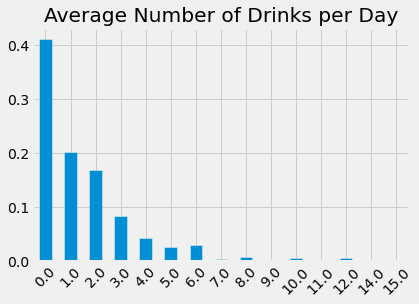

In [26]:
# enter your code here
nhanes['Drinks'] = nhanes['Avg_drinks_per_day'].fillna(0)
avg_drinks_ct = nhanes['Drinks'].value_counts().sort_index()
avg_drinks_dis = avg_drinks_ct / np.sum(avg_drinks_ct)
avg_drinks_dis.plot(kind='bar', rot=45).set(title='Average Number of Drinks per Day');

In [27]:
# print out result
mean = nhanes['Drinks'].mean()
var = nhanes['Drinks'].var()
print('Mean of average number of drinks per day %.3f' % mean)
print('Variance of average number of drinks per da: %.3f' % var)

Mean of average number of drinks per day 1.608
Variance of average number of drinks per da: 5.014


**4.2:** Fit a Poisson regression model using the same covariates as the model in **3.5** and `Drinks` as the outcome. 

In [29]:
# enter your code here
# take out the columns and drop NaN
dat = nhanes[['Drinks', 'Female', 'Age' ,'BMI', 'Marital_Status']].dropna()
dat['Married'] = (dat['Marital_Status']==1)*1
dat.endog = dat['Drinks']
dat.exog = sm.add_constant(dat[['Female', 'Age' ,'BMI', 'Married']])
model6 = sm.Poisson(dat.endog, dat.exog)
result6 = model6.fit(method="newton")
result6.summary()

Optimization terminated successfully.
         Current function value: 1.918939
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                 Drinks   No. Observations:                 5404
Model:                        Poisson   Df Residuals:                     5399
Method:                           MLE   Df Model:                            4
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.08093
Time:                        21:15:53   Log-Likelihood:                -10370.
converged:                       True   LL-Null:                       -11283.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3196      0.052     25.368      0.000       1.218       1.422
Female        -0.6930      0.022    -30.988      0.000      -0.737      -0.649
Age           -0.0170      0.001    -26.483      0.000      -0.018      -0.016
BMI            0.0114      0.001      7.738      0.000       0.008       0.014
Married       -0.1373      0.022     -6.249      0.000      -0.180      -0.094
==============================================================================
"""

In [30]:
### test making prediction and calculate errors
y_hat = np.round(result6.predict(dat.exog))
RMSE = np.sqrt(np.average((dat.endog -y_hat )**2))
RMSE

2.1409441251126062

**4.3:** How do we interpret the slope for `Age`?

**Solution:**  
If a person's age increases by 1, his/her expected number of drinks per day decreases by a multiplication of exp(-0.0170) if one's BMI and marital status remain the same.  

**4.4:** Compare a married female with unmarried male with same age and BMI, does the model result suggest which one has a higher expected value of average number of drinks per day?

**Solution:**  
Yes, the unmarried male has a higher expected number of drinks per day, because both slopes for `Female` and `Married` are negative and significant.

**4.5:** For a married female of age 36 with BMI 25, what is the expected number of drinks per day according to your model?

In [34]:
result6.params

const      1.319609
Female    -0.692962
Age       -0.017050
BMI        0.011355
Married   -0.137287
dtype: float64

In [36]:
# enter your code here
# notice you need to add 1 for intercept
new_data = np.array([1, 1, 36, 25, 1])
coef = result6.params
np.exp(sum(new_data*coef))

1.1728589385135453

In [37]:
# same but use model predict
result6.predict(new_data) 

array([1.17285894])

You're done with HW 6, the last homework!!! WoW~ 

* **Save and Checkpoint** from the File menu,
* **Close and Halt** from the File menu,
* **Rename your ipynb file**, replacing LASTNAME with your last name,
* **Upload** your file to the course website.